# The goal is to compute geometrical informations on every drops and to follow them through the coalescence events

### Measure the number of object and their surface with time

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import os.path
from skimage.feature import canny
from scipy import ndimage as ndi
import math
import pandas as pd
from skimage.measure import find_contours, label, regionprops, regionprops_table
from skimage.util import invert
from scipy import ndimage as ndi
from skimage.morphology import remove_small_holes, remove_small_objects
from skimage.segmentation import clear_border
from scipy.signal import find_peaks
from scipy.spatial.distance import cdist

# important variables:
#     - reorder : transition matrix between contours at t and at t0
#     - Num_ob : N° of each object (based on smallest num of composing drops)
#     - Num_ob_im : Num_ob values but only at ploting image times
#     - Num_dr : number of drops in each objects
#     - C_glob : contours list for ploting of image


########## Path definition : to uncomment ###########
# basic_path = 'path_to_folder'
# folder_name = 'folder_name'
# video_name = 'video_name'
# image_name = 'image_name_****.tiff'
# filepath = os.path.join(basic_path,folder_name,video_name,image_name)
### for example : to comment ###
import sys
sys.path.append("..")
filepath = os.path.join('image','fast_****.tiff')



################ parameters #################
t_start = 3*24                    # beginning
t_in = 6
scale = 83.75        # scale in px/mm
freq = 24           # fps of video
############## initialisation ###############
Nb_o, t1, Surf, Peri, Num_dr = [], [], [], [], []    # Number of objects, list of times, area, perimeter, Nb drop
Mask = []                                            # Mask to remove duplicate in post-treatment
reorder_all, Num_ob = [], []     # transition matrix, n° of objects at each time
C_glob, Num_ob_im = [], []          # for ploting : list of contour, n° of drop
t = 0                             # initialisation à t=0
t_in=0                            # compter of time for sampling, put to 0 at each coalescence event
T_im = []                         # n° of images where coalescence events

# import image sequence
drop_images = io.imread_collection(filepath, conserve_memory = True)

# core of the code
# loop on all images 
for img in drop_images:
    X, Y, Dt = [], [], []      # centroid positions and diameters of drops
    image = img[:,550:1650]    # crop image
    # inversion of image, fill in white, remove small artefacts and delete edges to get binarized image
    Inv = invert(image)
    Inv = Inv >210             # threshold : adapt to each case
    fill_inv = ndi.binary_fill_holes(Inv)
    fill_inv = remove_small_holes(fill_inv, 300)
    fill_inv = remove_small_objects(fill_inv, 300)          
    label_image = label(fill_inv,connectivity = 1)
    regions = regionprops(label_image)
    l_r = len(regions)
    
    # first image (t=0) : 
    # detection of drops and determine the initial order from left to right and top to bottom
    if t==0:
        contours = [find_contours(label_image==reg.label, level=0.2)[0] for reg in regions]    # get the contour of each object
        N_cont = l_r+2     # initialize at N+2 to be sure to keep value in following loop
        Nb_o.append(l_r)    
        len_0 = l_r
        
        # reorder the objects from left to right and top to bottom (based on centroid position)
        for props in regions: 
            xc_0, yc_0 = props.centroid
            X.append(xc_0/scale)
            Y.append(yc_0/scale)  
            Dt.append(props.equivalent_diameter_area)
        position = np.vstack((X,Y)).T    # list of centroid positions
        position_r = position//1.5       # list of centroid positions rounded to remove noise
        # sort position_r by x coordinates
        order = position_r[:,1].argsort()
        position_r = position_r[position_r[:,1].argsort()]
        # sort by ycoord and keep the sorting in xcoord
        order = order[position_r[:, 0].argsort(kind='mergesort')]   # transition matrix in drop N° for t=0 

        # C0 & P0 : ordered initial contour and positions of centroid (at t=0)
        # the N° of each drop will be its argument in the different folowwing arrays
        C0 = [contours[i] for i in order]
        P0 = position[order]*scale
        reorder = np.zeros(l_r)           # initialization of transition matrix
        P1 = P0.copy()                      # initialization of position list at instant t
        C1 = C0.copy()                      # initialization of contour list at instant t
        Nb_new = l_r
        Nb_old = Nb_new
        Nb_old_2 = Nb_old             
    # conditions to check if really a coalescence and not an artefact (compare Nb to 2 previous images)
    Nb_old_2 = Nb_old
    Nb_old = Nb_new
    Nb_new = l_r
    # reset the compter t_in at every coalescence event (so when Nb_o decreases) ==> change the rate of analyzes during 2 s
    if (Nb_new < Nb_old) and (Nb_new < Nb_old_2):
        t_in = 0
        P_old = P1.copy()    # keep old positions for detection issues if nb of object increase
        
    # main loop on all image + sampling 
    # - high rate at beginning during t_start
    # - high rate after coalescence during t_in = 2s
    # - low rate if t > t_in (every 4s)
    if (t >0 and t < t_start) or (t > 0 and (t_in/freq < 2)) or (t > 0 and (t%96==0)):
        t_in+=1
        
        # detect objects and measure contours & number of objects
        #label_image = label(fill_inv)
        #regions = regionprops(label_image)
        contours = [find_contours(label_image==reg.label, level=0.2)[0] for reg in regions]
        Nb_o.append(l_r)
    
        # Complex part : associate each object of instant t-1 to a contour detected at time t
        # The association is done by minimizing the distance between the centroid of each drop at instant t-1 to all the contour
        # at instant t. The minimum will give the corresponding contour(t) for each drop(t-1)
        for k in range(len(C0)):
            # reorder is the transition matrix from the new contours lits to the global C0 list : so it is an array of 
            # len(C0) with each column associated to an initial drop and corresponding to the arg of the daugther drop 
            # in contours
            
            # nb of object increase : detection pB so compare to last contour before "coalescence"
            if Nb_new > Nb_old:
                reorder[k] = int(np.argmin([cdist([P_old[k]],contours[i][0::10]).min() for i in range(l_r)]))
            
            # normal case
            else:
                reorder[k] = int(np.argmin([cdist([P1[k]],contours[i][0::10]).min() for i in range(l_r)]))
                
            # argmin of cdist between P1 and contours (sampled each 10 points for computation speed)
            reorder = reorder.astype(int)
            
        P1 = np.array([regions[j].centroid for j in reorder])      # centroids of corresponding daughter drops at time t
        C1 = [contours[i] for i in reorder]                        # contours at time t
        
        # regroup drop N° by group:  
        # a: list of drop N°, grouped by N° of object (drops in same object are in same group)
        a = [[i for i, x in enumerate(reorder) if x==y] for j,y in enumerate(np.unique(reorder))] 
        a.sort()
        # get corresponding object N° (rpz by N° of first drop in it) associated to each drop
        # example if drops 0,3 & 4 coalesced and 5&6 as well : [0,1,2,0,0,5,5]
        b = np.vstack((np.hstack(np.array(a,dtype=object)),np.hstack(np.array([[l[0]]*len(l) for l in a],dtype=object))))
        b = b[:, b[0].argsort()][1,:]
        b_un = np.unique(b)  # unique drops
        
        # save transition matrix, image nb, contour and object N° for ploting purposes (after each coalescence event)
        if l_r < N_cont:
            reorder_all.append(reorder)  # transition matrixes
            T_im.append(t)               # time
            C_glob.append(C1)            # reordered contour
            Num_ob_im.append(b)          # corresponding n° of each objects
            #print((t,len(regions),len(contours)))
        
        # save the Nb of drop in each object : for each drop, count the nb of time the corresponding drop N° appear in reorder   
        Num_dr.append([len(np.where(reorder==reorder[i])[0]) for i in range(len_0)]) 
        N_cont = l_r
        Num_ob.append(b)  # N° of object
        Mask.append([True if i in b_un else False for i in range(Nb_o[0])]) # mask to remove duplicates
        
        # Measurements : 
        # surface, perimeter and number of drops in each object
        Surf.append([regions[k].area/(scale*scale) for k in reorder])
        Peri.append([regions[k].perimeter/scale for k in reorder])      
        t1.append(t/freq) 
    t+=1

reorder_all.append(reorder)
    
Surf = np.array(Surf)
Peri = np.array(Peri)
reorder_all = np.array(reorder_all)
Num_ob = np.array(Num_ob, dtype=int)
Num_ob_im = np.array(Num_ob_im, dtype=int)
Mask = np.array(Mask)

## Visualisation

A color for each drop in the beginning. When they coalesce the color is the one of the drop whose centroid was the more up-left of both

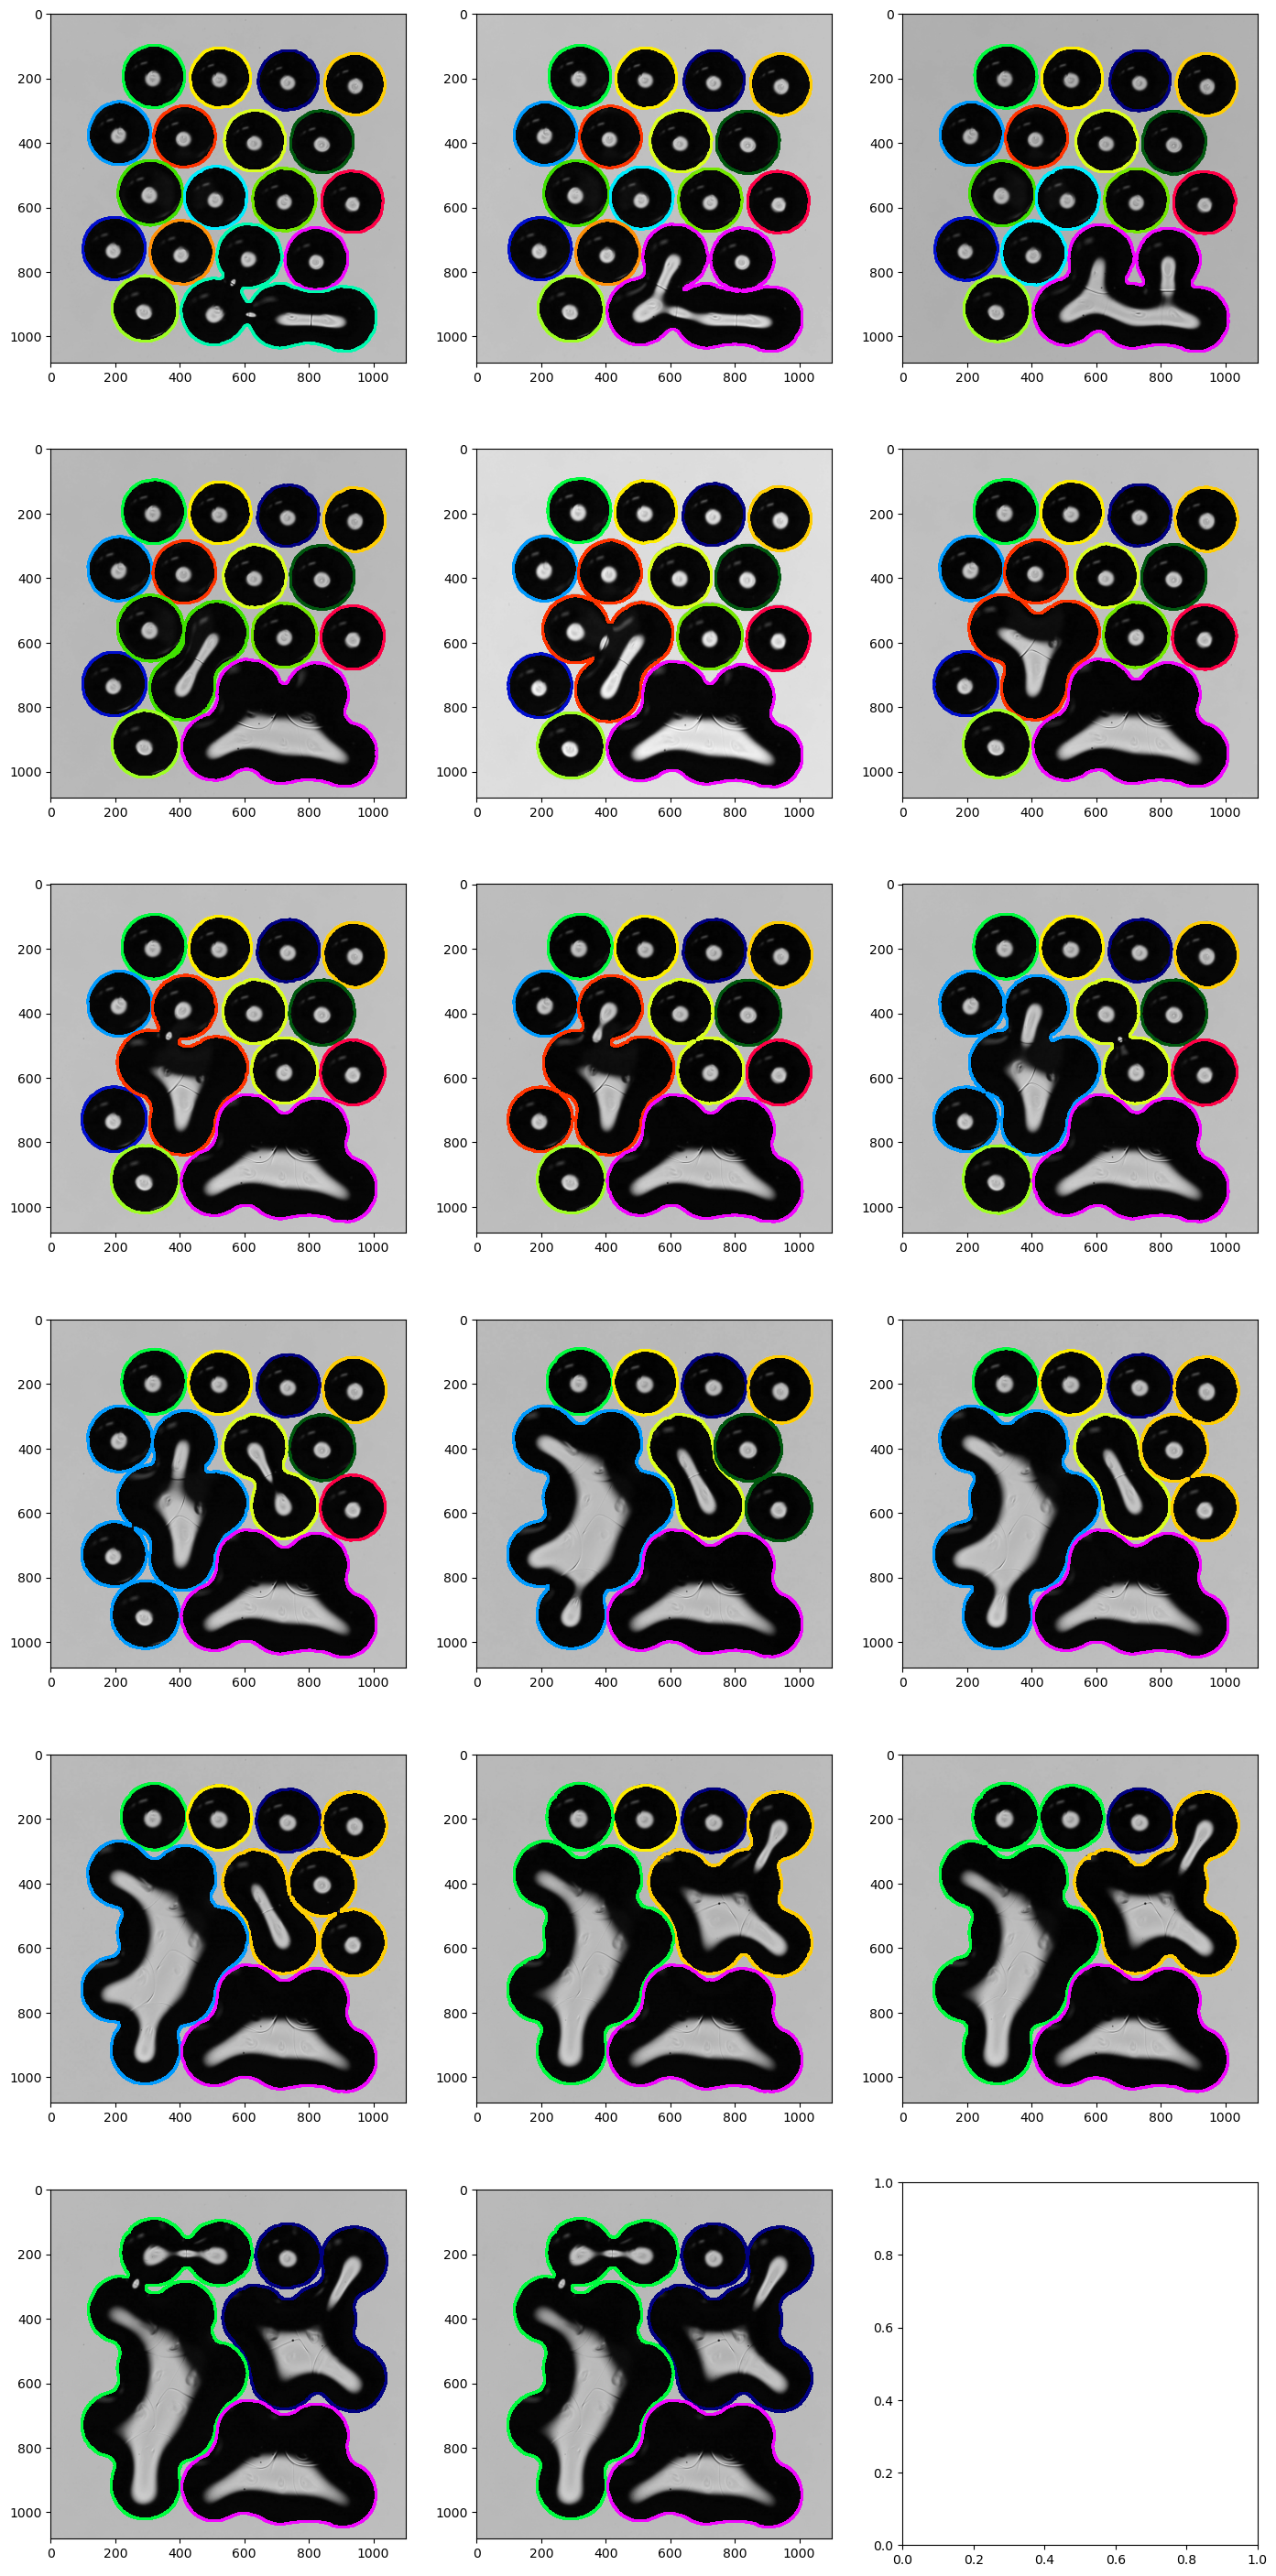

In [2]:
# visualization of all images after coalescence events
import math
fig, axes = plt.subplots(ncols=3, nrows=math.ceil((len(T_im)+1)/3), figsize=(17, 6*math.ceil((len(T_im)+1)/3)))
ax = axes.ravel()
plt.gray()

drop_images = io.imread_collection(filepath, conserve_memory = True)
j=0    # compter of step
col = plt.cm.gist_ncar(np.linspace(0.8,0,len(C1)))
test = np.array([ 10, 5, 16, 4, 13,  2,  6,  15, 9, 12, 8, 1,  14,  3,  0,  7, 11])
# test = np.array([8, 4, 6,  2,1, 9,  5,  3,  0,  7])
col=col[test]
#np.random.shuffle(col)

# iterate on all images juste after coalescence events
for i in T_im:
    C_loc = C_glob[j]   # contours of step j
    # plot contour for each object k
    for k in range(len(C_loc)):
                ax[j].plot(C_loc[k][:,1], C_loc[k][:,0],'o', color=col[Num_ob_im[j][k]],markersize=1)
            
    ax[j].imshow(drop_images[i][:,550:1650], cmap='gray')
    j+=1

# plot state at Tf
for k in range(len(C1)):
                 ax[len(T_im)].plot(C1[k][:,1], C1[k][:,0],'o', color=col[Num_ob_im[-1][k]],markersize=1)
ax[len(T_im)].imshow(image, cmap='gray')
plt.show()

## Save data

In [45]:
## save all the data in npy files
import os

basic_path = 'C:/Users/antob/OneDrive/Documents/These_Antoine/Manips'
folder_name_save = 'depot_goutte_controle/array/data'

filepath_save = os.path.join(basic_path,folder_name_save,video_name)

if not os.path.exists(filepath_save):
    os.mkdir(filepath_save)

with open(os.path.join(filepath_save,'Surf.npy'), 'wb') as f:    # surface
    np.save(f, Surf)
with open(os.path.join(filepath_save,'Peri.npy'), 'wb') as f:    # perimeter
    np.save(f, Peri)
with open(os.path.join(filepath_save,'Num_ob.npy'), 'wb') as f:    # N° of corresponding object 
    np.save(f, Num_ob)
with open(os.path.join(filepath_save,'Num_dr.npy'), 'wb') as f:    # Number of drops in each object
    np.save(f, Num_dr)
with open(os.path.join(filepath_save,'Mask.npy'), 'wb') as f:    # Mask to remove duplicates
    np.save(f, Mask)
with open(os.path.join(filepath_save,'t1.npy'), 'wb') as f:    # time 
    np.save(f, t1)
with open(os.path.join(filepath_save,'C_glob.npy'), 'wb') as f:    # List of contours at each coal step (for visualisation)
    np.save(f, np.array(C_glob, dtype=object))
with open(os.path.join(filepath_save,'Num_ob_im.npy'), 'wb') as f:    # N° of corresponding object at coal step
    np.save(f, Num_ob_im)
with open(os.path.join(filepath_save,'reorder_all.npy'), 'wb') as f:    # Transition matrix at each coal step
    np.save(f, reorder_all)
with open(os.path.join(filepath_save,'T_im.npy'), 'wb') as f:    # time (in n° of img) of coal steps
    np.save(f, T_im)
with open(os.path.join(filepath_save,'Nb_o.npy'), 'wb') as f:    # Number of drops at each time step
    np.save(f, Nb_o)

